In [1]:
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import matplotlib.pyplot as plt
%matplotlib inline

# Minimum funkcije in algoritem BFGS

Iščemo mimum funkcije $(\theta_0-2)^2+(\theta_1-3)^2-42$. Funkcijo in njen gradient zapišemo tako, da ima kot parametre vektor $\Theta$.

In [2]:
def cost(theta):
    return (theta[0]-2)**2 + (theta[1]-3)**2 - 42

def grad(theta):
    return np.array([2*(theta[0]-2), 2*(theta[1]-3)])

In [3]:
theta = np.array([0, 0])
cost(theta), grad(theta)

(-29, array([-4, -6]))

Za iskanje minimuma uporabimo funkcijo fmin_l_bfgs_b ki implementira algoritem [Broyden–Fletcher–Goldfarb–Shanno z omejenim spominom](https://en.wikipedia.org/wiki/Limited-memory_BFGS).

In [4]:
theta0 = np.array([0, 0])
res = fmin_l_bfgs_b(cost, theta0, grad)
res

(array([ 2.,  3.]),
 -42.0,
 {'funcalls': 3,
  'grad': array([ 0.,  0.]),
  'nit': 2,
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

Rezultati se ujemajo s pričakovanji. Naša cenovna funkcija ima minimum v točki [2, 3], vrednost funkcije v tej točki je -17, konvergenca algoritma pa je izjemno hitra, saj je minimum našel s samo tremi klici kriterijske funkcije in njenega gradienta.

# Metoda končnih razlik

Vedno se splača preveriti, ali smo funkcijo, ki izračuna gradient, implenentirali pravilno oziroma ali je analitična rešitev (izračun gradienta) prava glede na cenovno funkcijo. Eden od načinov, kako to preverimo je, da gradient izračunamo z metodo končnih razlik. Gradient računamo pri izbrani vrednosti parametrov $\Theta$. Če bi imeli opravka s funkcijo enega samega parametra, bi z metodo končnih razlik odvod ocenili kot $f((\theta+\epsilon)-f(\theta-\epsilon)/(2\epsilon)$. Ker pa imamo opravka s funkcijo več parametrov ($\Theta$ je vektor) parcialne odvode izračunamo tako, da vsakič spreminjamo enega izmed parametrov.

In [5]:
def grad_approx(f, theta, e=1e-3):
    return np.array([(f(theta+eps) - f(theta-eps))/(2*e)
                     for eps in np.identity(len(theta)) * e])

In [6]:
grad_approx(cost, theta0), grad(theta0)

(array([-4., -6.]), array([-4, -6]))

Dela! Gradienta sta enaka. Seveda bo pri bolj kompleksnih kriterijskih funkcijah ta enakost približna in tudi odvisna od vrednosti $\epsilon$.

# Linearna regresija

Algoritma L-BFGS sedaj uporabimo za linearno regresijo. Za podatke uporabimo zbirko housing.

In [7]:
import Orange
data = Orange.data.Table("housing")
print("Examples: %d" % len(data))
print("Attributes: %d" % len(data.domain.attributes))

Examples: 506
Attributes: 13


Orange-ov objekt `data` vsebuje opis spremenljivk ter dve tabeli, tabelo atributov $X$ in vektor razredov $y$. Ker bomo tu potrebovali samo ta dva zapisa, in ker sta ta že v zapisu numpy, uvedemo novi spremenljivki, ki kažeta na te objekte. Matriko $X$ razširimo s kolono enic za računanje $\theta_0$.

In [8]:
X, y = data.X, data.Y
X = np.column_stack((np.ones(len(X)), X))

Za linearno regresijo zapišemo cenovno funkcijo in funkcijo, ki vrača gradient.

In [9]:
def J(theta, X, y):
    return (1 / (2 * len(data))) * np.sum((X.dot(theta) - y)**2)

def grad(theta, X, y):
    return (1 / len(data)) * (X.dot(theta) - y).dot(X)

In [10]:
theta0 = np.zeros(X.shape[1])

In [11]:
res = fmin_l_bfgs_b(J, x0=theta0, args=(X, y), fprime=grad)
res

(array([  3.57967712e+01,  -1.08093081e-01,   4.66882362e-02,
          2.13456086e-02,   2.64074512e+00,  -1.77178974e+01,
          3.85310804e+00,   8.50473295e-04,  -1.47132044e+00,
          3.03650373e-01,  -1.22674708e-02,  -9.38811529e-01,
          9.42404540e-03,  -5.22704439e-01]),
 10.948023361492092,
 {'funcalls': 2557,
  'grad': array([-0.00088407, -0.00499033,  0.00982557,  0.00709474, -0.00335345,
         -0.00076431,  0.0021781 ,  0.03443767,  0.00132969,  0.00575186,
          0.30465147,  0.02588604,  0.21551422,  0.0034818 ]),
  'nit': 2212,
  'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

Tudi tu je, glede na velikost podatkov, konvergenca hitra. Ne vemo sicer, kako dober je model. V tej točki bi morali oceniti napovedno točno modela (prečno preverjanje) ter pregledati, ali je model skladen z domenskim znanjem oziroma ali so uteži atributov ($\Theta$) smiselne. Za končno uporabo in interpretacijo bi morali podatke ustrezno normalizirati (vsaki koloni odštejemo povprečne vrednosti in delimo s standardno deviacijo).

## Preiskus delovanja na sintetični podatkih

Ker ni lepo, da ostanemo samo z nekim seznamom parametrov (zgoraj), tu preverimo delovanje linearne regresije, kot smo jo implementirali, na sintetičnih podatkih. In sicer bomo te generirali za funkcijo $y=3x+42$, kjer pa bomo poleg kolone z vrednostjo $x$ dodali tudi kolono z naključnimi števili. Lahko bi takih, naključnih kolon dodali več, a boo tu dodali eno samo.

In [12]:
m = 10
xs = np.arange(0, m, 1)
y = (3 * xs + 42)  + np.random.normal(0, 3, m)
X = np.array([[i, np.random.rand()*m] for i in xs])
X = np.column_stack((np.ones(len(X)), X))

In [13]:
theta0 = np.zeros(X.shape[1])
res = fmin_l_bfgs_b(J, x0=theta0, args=(X, y), fprime=grad)
res

(array([ 43.23395491,   2.27972901,   0.52357615]),
 0.039912864085048398,
 {'funcalls': 12,
  'grad': array([  8.48707069e-11,   4.17596357e-10,   6.32623714e-10]),
  'nit': 10,
  'task': b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

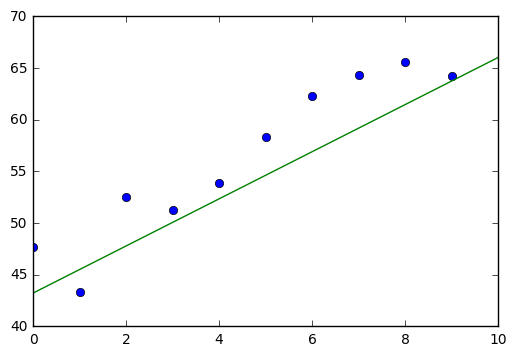

In [14]:
plt.plot(X[:, 1], y, "o")
p = np.array([[1, 0, 0], [1, 10, 0]])
plt.plot(p[:, 1], p.dot(res[0]));

Dela. Tudi parametre modela kar dobro zadane, glede na to, da je primerov samo 10. Z zvišanjem števila primerov dobimo še boljo oceno parametrov. Poskusi!